In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import gym
import gym_minigrid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [27]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import torch

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3, 3),  # number of cells
            # shape_=(3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency) 6 x 6 x 3
        # print(full_grid.shape)
        
        flattened_grid = full_grid.ravel()
        # full_grid_tensor = torch.tensor(full_grid, dtype=torch.float32)
        # flattened_grid = torch.flatten(full_grid_tensor, end_dim=1)
        # flattened_grid = flattened_grid.detach().numpy()

        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [28]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [29]:
import torch
def log_policy_rollout(policy, env_name, pytorch_policy=True):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)

    # Initialize environment
    observation = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy: 
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0]
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    
    show_video()

In [30]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutBuffer():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()
        
    def insert(self, step, done, action, log_prob, reward, obs):    
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)
        
    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1, requires_grad=False)
        # Assuming Discrete Action Space
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)  
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)
        
    def compute_returns(self, gamma):
        # Compute Returns until the last finished episode
        self.last_done = (self.done == 1).nonzero().max()  
        self.returns[self.last_done + 1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]
        
    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(
            SubsetRandomSampler(range(self.last_done)),
            batch_size,
            drop_last=True)
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.layers import GraphAttentionLayer, SpGraphAttentionLayer, readout_function
from utils.layers import GraphConvolution
import scipy.sparse as sp
from utils.utils import normalize_adj, sparse_mx_to_torch_sparse_tensor

N1 = 6
N2 = 6
grid_map = np.zeros( (N1, N2) ).astype(np.int64)
A = np.zeros( (N1*N2, N1*N2) )
counter = 0
for i in range(grid_map.shape[0]):
    for j in range(grid_map.shape[1]):
        grid_map[i,j] = counter
        counter += 1

for i in range(grid_map.shape[0]):
    for j in range(grid_map.shape[1]):
        if i-1>=0:
            A[grid_map[i, j], grid_map[i-1, j]] = 1
            A[grid_map[i-1, j], grid_map[i, j]] = 1
        if i+1<N1:
            A[grid_map[i, j], grid_map[i+1, j]] = 1
            A[grid_map[i+1, j], grid_map[i, j]] = 1
        if j-1>=0:
            A[grid_map[i, j], grid_map[i, j-1]] = 1
            A[grid_map[i, j-1], grid_map[i, j]] = 1
        if j+1<N2:
            A[grid_map[i, j], grid_map[i, j+1]] = 1
            A[grid_map[i, j+1], grid_map[i, j]] = 1
A = sp.csr_matrix(A)
A = normalize_adj(A + sp.eye(A.shape[0]))
A = sparse_mx_to_torch_sparse_tensor(A)

class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions
        
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_actions)
        )
        
    def forward(self, state):
        x = self.fc(state)
        return x

class GCNActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, dropout = 0.0):
        super(GCNActorNetwork, self).__init__()
        self.nfeat = num_inputs # 3
        self.nhid = hidden_dim # 32
        self.nclass = num_actions # 7?

        self.gc1 = GraphConvolution(self.nfeat, self.nhid)
        self.gc2 = GraphConvolution(self.nhid, self.nhid)
        self.dropout = dropout
        self.out_layer = nn.Linear(self.nhid, self.nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        # x = readout_function(x, 'avg')
        x = torch.mean(x, dim=0).squeeze()
        output = F.relu(self.out_layer(x))
        return output

In [40]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from utils.utils import count_model_params

class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate,
                 batch_size, policy_epochs, entropy_coef=0.001):
        self.actor = GCNActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.actor(state, A)
        # To generate the probability of action, we assume its state has categorical distribution.
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def evaluate_actions(self, state, action):
        logits = self.actor(state, A)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy
    
    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
    
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
    
                # Compute the mean loss for the policy update using 
                # action log-probabilities and policy returns
                policy_loss = -(log_probs_batch * returns_batch).mean()
                # Compute the mean entropy for the policy update 
                entropy_loss = -entropy_batch.mean()
                
                loss = policy_loss + self.entropy_coef * entropy_loss
                
                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()
                
    @property
    def num_params(self):
        return count_model_params(self.actor)

In [41]:
from IPython.display import clear_output
from utils.utils import AverageMeter, plot_learning_curve
import time

def train(env, rollouts, policy, params, seed=123):
    # SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
    shape = (int(env.observation_space.shape[0]/env.observation_space.shape[1]), env.observation_space.shape[1])
    print(shape)

    rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(params.num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        prev_obs = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()
        
        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done:
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info: 
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                obs = env.reset()
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs
            
            obs_reshape = torch.reshape(obs, shape)
            print(obs_reshape.shape)
            action, log_prob = policy.act(obs_reshape)
            obs, reward, done, info = env.step(action)

            rollouts.insert(step, torch.tensor(done, dtype=torch.float32), action, log_prob, 
                            torch.tensor(reward, dtype=torch.float32), 
                            prev_obs)
            
            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward
        
        # Use the rollout buffer's function to compute the returns for all stored rollout steps. (requires just 1 line)
        rollouts.compute_returns(params['discount'])
        
        rollout_done_time = time.time()

        
        # Call the policy's update function using the collected rollouts        
        policy.update(rollouts)

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, 
                                                                                                avg_eps_reward.avg, 
                                                                                                rollout_time.avg,
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate

In [42]:
from utils.utils import ParamDict
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(nonwrapped_env)    
    obs_size = env.observation_space.shape[0]
    print(env.observation_space.shape)
    num_actions = env.action_space.n

    rollouts = RolloutBuffer(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')
    
    policy = policy_class(env.observation_space.shape[1], num_actions, **params.policy_params)
    return env, rollouts, policy

In [43]:
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 50,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-8x8-v0',  # we are using a tiny environment here for testing
)

In [44]:
env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

(108, 3)
(36, 3)
Training model with 1415 parameters...
torch.Size([36, 3])


RuntimeError: The size of tensor a (108) must match the size of tensor b (3) at non-singleton dimension 1

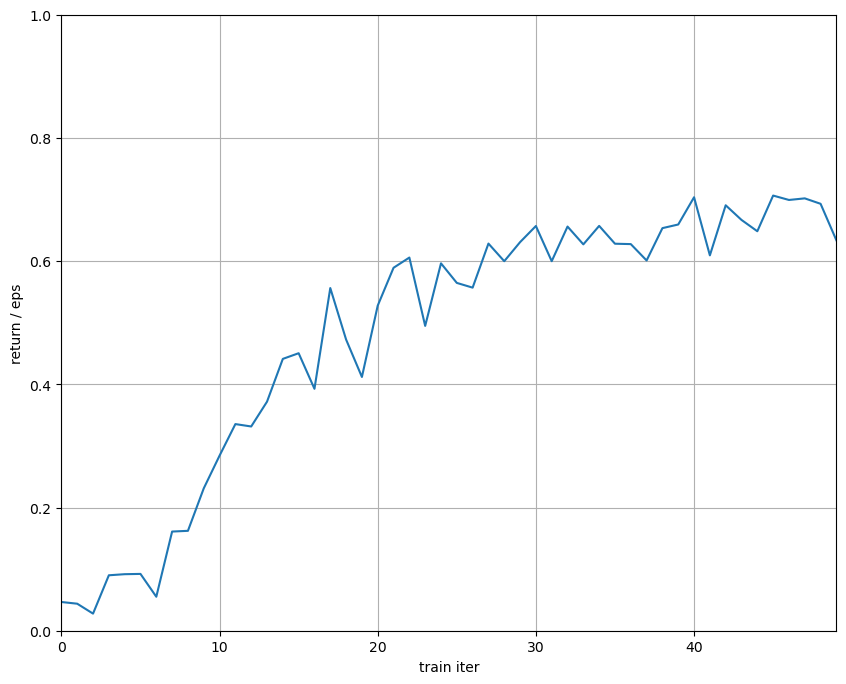

Total reward: 0.874
Total length: 7


Total reward: 0.874
Total length: 7


Total reward: 0.838
Total length: 9


In [ ]:
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)